<a href="https://colab.research.google.com/github/MalikHasnat1999/ZTM_Tensorflow/blob/master/07_Milestone_Project_Food_Vision_Big.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What we are going to do is beat DeepFood Research Paper

# Import Libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Helper Functions

In [ ]:
def unzip_file(file_name):
  zip_ref = zipfile.ZipFile(file_name)
  zip_ref.extractall()
  zip_ref.close()



# Create Tensorboard callbacks (functionized cause we need to created one for each model)
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates TensorBoard Callback instance to store log files
  Store log files with the filepath
      ""dir_name/experiments_name/Current_DateTime"
  Args:
    dir_name: Target directory to store TensorBoard log files
    experiment_name: Name of the experiment directory eg(Efficient_model_1)_

  Returns:
    [TensorBoard Callback]
  """
  LOG_DIR = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime('%d%m%y-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)
  print(f"Saving the Tensorboard log files to {LOG_DIR}")
  return tensorboard_callback



def create_checkpoint(path):
  """
  Create ModelCheckpoint callback to save model's progress
  during training

  Args:
    path: Path of directory where to save progress
          e.g "my_checkpoints/checkpoint.ckpt"
  """
  checkpoint_path = path
  checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                     verbose=1,
                                     save_weights_only=True,
                                     save_best_only=True,
                                     save_freq="epoch",
                                     monitor="val_accuracy")
  return checkpoint

# Check GPU

Google collab offers free GPU, but all of them are not compatible with mixed precision training

Google Colab offer
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-9130ec60-05c9-b24b-a263-063a2d773f34)


# Download the Dataset

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
# List all of the datasets
datasets_list = tfds.list_builders()
print("food101" in  datasets_list)

True


In [ ]:
# Load in the data (takes 5-6 minutes to download)
(train_dataset, test_dataset), ds_info = tfds.load(name="food101",
                                                   split=["train", "validation"],
                                                   shuffle_files=False,
                                                   as_supervised=True,# gets data returned in tuple format (data, label)
                                                   with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteYUTRTL/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteYUTRTL/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
len(train_dataset), len(test_dataset)

(75750, 25250)

In [ ]:
y_true =  []
for images , labels in test_dataset:
  labels = tf.one_hot(labels, depth=101)
  y_true.append(labels.numpy().argmax())

In [ ]:
y_true[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

# Exploring our Dataset

To become one with the date we need to find the following:

* Class_names
* Shape of our input data (image tensors)
* The data types of our input data
* What the labels look like? (e.g they are one-hot encoded or they are label encoded)
* Do the labels match up with class names?

In [ ]:
# features from food101 tfds
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# get class names
class_names = ds_info.features["label"].names
class_names[:5], len(class_names)

(['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare'],
 101)

In [ ]:
# take one sample of the train data
train_one_sample = train_dataset.take(1)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
# output info about our training sample
for image, label in train_one_sample:
  print(f"""
        Image shape : {image.shape}
        Image DataType : {image.dtype}
        Target Class from food101 (tensor form) : {label}
        Class name (string form) : {class_names[label.numpy()]}
        """)


        Image shape : (512, 512, 3)
        Image DataType : <dtype: 'uint8'>
        Target Class from food101 (tensor form) : 56
        Class name (string form) : huevos_rancheros
        


In [ ]:
# how does our image tensor from food101 look like
# image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

(-0.5, 511.5, 511.5, -0.5)

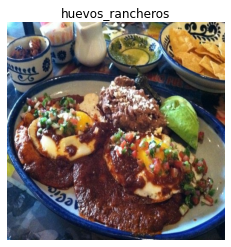

In [ ]:
# plt.imshow(image)
# plt.title(class_names[label.numpy()])
# plt.axis(False)

## ii).Preprocess the data

Neural Network perform best when our data is in certain way (eg. batched, normalized etc).

How ever not all dataset from tfds comes like this 

What we know about our data:
* In `uint8` type
* Consists of all different type of tensors
* Not Scaled (data is not normalized)

What we know models like:
* Data in `float32` dtype
* For batchs, tensorflow like all batches to be in certain size
* Scaled (value b/w 0 and 1)

Since we are going to be using an EfficientNetBX model from tf.kera.application so we do not need to rescale out model (these architecure have rescaling built-in)

This meand our function need to:
1. Reshape our images to all the same size
2. Convert the dtype our image tensor from `uint8` to `float32`

In [ ]:
# Make a functionn to preprocessing images
def preprocess_image(image, label, image_shape=224):
  """
  Convert the image dtype from 'uint8'   -> 'float32'
  image shape to [image_shape, image_shape, color_Channels]

  Returns:
    (float32_image, label) tuple
  """

  image = tf.image.resize(image, [image_shape, image_shape]) # reshape target image
  return tf.cast(image, tf.float32), label  # return (float32_image, label) tuple

In [ ]:
# preprocessed_image = preprocess_image(image,label)[0] # get only the image
# preprocessed_image
# print(f"Image Before Preprocessing : \n {image} \n Shape: {image.shape} \n Image_dtype: {image.dtype}")
# print(f"Image After Preprocessing : \n {preprocessed_image} \n Shape: {preprocessed_image.shape} \n Image_dtype: {preprocessed_image.dtype}")

## iii).Batch & Prepare Data

For more resourses read through
https://www.tensorflow.org/guide/data_performance

In [ ]:
# Map preprocessing function to training data and parallelize
train_data = train_dataset.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data and pareallelize
test_data = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [ ]:
y_true_2 =  []
for images , labels in test_dataset:
  y_true_2.append(labels.numpy())

In [ ]:
y_true_2[:20]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100, 4, 32, 32, 3, 8, 85, 84, 60, 29, 80]

> "Hey Tensorflow, map these preprocessing functions (`preprocessed_image`) across out training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new bathes (prefetch) whilst the model is looking through (finding patterns) the current batch"

# Create modelling callbacks

we are going to create couple of callbacks to help us train the model:
* TensorBoard Callaback to log training results (so we can visualize them later if needed)
* Checkpoint Callback to save our model performance after feature extraction


In [ ]:
# import from the helper function 

# Set up mixed precision training

Mixed precision utilizes a combination of float32 and float16 datatypes to speed up the model performance

In [ ]:
# Turn on the mixed precision training
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

# Build Feature Extraction model

In [ ]:
# create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create layers
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="GlobalAveragePooling_layer")(x)
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax", name="output_layer", dtype=tf.float32)(x)

# create model using inputs and ouputs
model = tf.keras.Model(inputs, outputs)

# compile the model
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

16719872/16705208 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAveragePooling_layer   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# fit the model
model_history = model.fit(train_data,
                          epochs=10,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=int(0.15 * len(test_data)))

Epoch 1/10
2368/2368 [==============================] - 308s 129ms/step - loss: 1.3743 - accuracy: 0.6461 - val_loss: 1.1483 - val_accuracy: 0.6901
Epoch 2/10
2368/2368 [==============================] - 305s 128ms/step - loss: 1.2348 - accuracy: 0.6791 - val_loss: 1.1012 - val_accuracy: 0.7010
Epoch 3/10
2368/2368 [==============================] - 305s 128ms/step - loss: 1.1416 - accuracy: 0.7007 - val_loss: 1.0738 - val_accuracy: 0.7116
Epoch 4/10
2368/2368 [==============================] - 304s 127ms/step - loss: 1.0755 - accuracy: 0.7163 - val_loss: 1.0629 - val_accuracy: 0.7145
Epoch 5/10
2368/2368 [==============================] - 306s 128ms/step - loss: 1.0250 - accuracy: 0.7291 - val_loss: 1.0619 - val_accuracy: 0.7169
Epoch 6/10
2368/2368 [==============================] - 306s 128ms/step - loss: 0.9811 - accuracy: 0.7387 - val_loss: 1.0653 - val_accuracy: 0.7124
Epoch 7/10
2368/2368 [==============================] - 305s 128ms/step - loss: 0.9477 - accuracy: 0.7468 - val_

In [ ]:
results = model.evaluate(test_data)

790/790 [==============================] - 95s 119ms/step - loss: 1.0829 - accuracy: 0.7109


In [ ]:
pred_probs = model.predict(test_data)
pred_probs[1]

array([2.47174903e-05, 8.18964145e-06, 6.66293708e-05, 1.93091415e-04,
       2.87763942e-05, 8.78619903e-05, 3.44596105e-04, 2.54498009e-05,
       1.64172379e-04, 3.28103706e-05, 1.75631576e-04, 4.13267917e-05,
       8.56529514e-04, 1.28224521e-04, 1.71933236e-04, 3.49991169e-04,
       7.53182248e-05, 2.07064495e-05, 9.33498964e-02, 4.61235104e-05,
       2.33020241e-04, 1.45602089e-05, 2.26244170e-04, 1.83452466e-05,
       2.42530648e-03, 1.07029598e-04, 1.12361438e-03, 9.50430112e-04,
       1.43661418e-05, 4.88047908e-06, 3.19456990e-06, 1.08808820e-06,
       3.84138722e-04, 3.01000932e-06, 7.31796172e-06, 1.20922967e-04,
       7.01419718e-04, 1.23583319e-04, 1.02260992e-06, 1.52735927e-04,
       1.40903730e-05, 4.30084486e-03, 4.54368710e-04, 6.39234568e-05,
       3.72788083e-04, 1.00263380e-04, 1.52173277e-04, 2.25174997e-04,
       9.61967817e-05, 1.42388904e-04, 3.22799402e-04, 2.44673633e-04,
       2.91966135e-04, 1.29349355e-05, 1.13381946e-03, 4.91387873e-05,
      

In [ ]:
y_pred = pred_probs.argmax(axis=1)
y_pred[:10]

array([29, 81, 91, 53, 97, 97, 10, 31,  3,  8])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.7108514851485148

In [ ]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
model.save("/content/drive/MyDrive/Saved_Models/FoodVision101/EfficientNetB0")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Saved_Models/FoodVision101/EfficientNetB0/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Saved_Models/FoodVision101/EfficientNetB0/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Load model previously saved above
loaded_model_1 = tf.keras.models.load_model("/content/drive/MyDrive/Saved_Models/FoodVision101/EfficientNetB0")

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_model = loaded_model_1.evaluate(test_data)
results_loaded_model

790/790 [==============================] - 90s 109ms/step - loss: 1.0933 - accuracy: 0.7076


[1.0932648181915283, 0.707603931427002]

# Saving & Loading model

In [ ]:
results

[1.0932649374008179, 0.707603931427002]

In [ ]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables
print(np.isclose(results, results_loaded_model)), print(f"Difference {results[1]-results_loaded_model[1]}")

[ True  True]
Difference 0.0


(None, None)

## Check each layer dtype policy (are we using mixed precicion) 

In [ ]:
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
GlobalAveragePooling_layer True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "float32">


Going throught the above we see:
* `layer.name`: human readable name of a particular layer
* `layer.trainable`: Is the layer trainable or not?
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with 

In [ ]:
for i, layer in enumerate(model.layers[1].layers):
  print(i,layer.name,layer.trainable,layer.dtype, layer.dtype_policy)

0 input_1 False float32 <Policy "float32">
1 rescaling False float32 <Policy "mixed_float16">
2 normalization False float32 <Policy "mixed_float16">
3 stem_conv_pad False float32 <Policy "mixed_float16">
4 stem_conv False float32 <Policy "mixed_float16">
5 stem_bn False float32 <Policy "mixed_float16">
6 stem_activation False float32 <Policy "mixed_float16">
7 block1a_dwconv False float32 <Policy "mixed_float16">
8 block1a_bn False float32 <Policy "mixed_float16">
9 block1a_activation False float32 <Policy "mixed_float16">
10 block1a_se_squeeze False float32 <Policy "mixed_float16">
11 block1a_se_reshape False float32 <Policy "mixed_float16">
12 block1a_se_reduce False float32 <Policy "mixed_float16">
13 block1a_se_expand False float32 <Policy "mixed_float16">
14 block1a_se_excite False float32 <Policy "mixed_float16">
15 block1a_project_conv False float32 <Policy "mixed_float16">
16 block1a_project_bn False float32 <Policy "mixed_float16">
17 block2a_expand_conv False float32 <Policy 

# 1.Preparing our model's layers for fine-tuning

Fine-tune the feature extraction model to beat the DeepFood paper.

Like all good cooking shows, I've saved a model I prepared earlier (the feature extraction model from above) to Google Storage.

You can download it to make sure you're using the same model as originall trained going forward.

In [ ]:
# Download the saved model from Google Storage
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
# !mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
# !unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

In [ ]:
# # Load and evaluate downloaded GS model
# gs_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
# Get a summary of the downloaded model
# gs_model.summary()

In [ ]:
# How does the loaded model perform? (evaluate it on the test dataset)
# results_gs = gs_model.evaluate(test_data)

In [ ]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
# fine Tuning with all layers
# gs_model.layers[1].trainable = True

In [ ]:
# Check to see what dtype_policy of the layers in your loaded model are
# for i, layer in enumerate(gs_model.layers):
#   print(i, layer.name, layer.dtype_policy)

In [ ]:
for layer in model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fbbaa581f10> True
<keras.engine.functional.Functional object at 0x7fbba9dc6750> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fbba4ad0890> True
<keras.layers.core.dense.Dense object at 0x7fbba9f8ee50> True


In [ ]:
model.layers[1].trainable = True

# 2.Setting up Early Stopping and ModelCheckpoint

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)


# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
checkpoint_path_2 = "gs_model_fine_tuned_checkpoint/checkpoint.ckpt"
create_checkpoint_2 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_2,
                                                         monitor="val_loss",
                                                         verbose=1,
                                                         save_best_only=True,
                                                         save_freq="epoch")

#

In [ ]:
# reCompile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=["accuracy"]
)

In [ ]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
model_1_finetune_history = model.fit(train_data,
                           epochs=2,
                           steps_per_epoch=len(train_data),
                           validation_data=test_data,
                           validation_steps=int(0.15 * len(test_data)),
                           callbacks=[create_tensorboard_callback("gs_model_tensorboard",
                                                                 "gs_model_fine_tuned"),
                                     create_checkpoint_2,early_stopping])

Saving the Tensorboard log files to gs_model_tensorboard/gs_model_fine_tuned/080222-100616
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - ETA: 0s - loss: 0.9256 - accuracy: 0.7521
Epoch 00001: val_loss improved from inf to 0.80175, saving model to gs_model_fine_tuned_checkpoint/checkpoint.ckpt


INFO:tensorflow:Assets written to: gs_model_fine_tuned_checkpoint/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: gs_model_fine_tuned_checkpoint/checkpoint.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 1199s 490ms/step - loss: 0.9256 - accuracy: 0.7521 - val_loss: 0.8018 - val_accuracy: 0.7767


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/2
2368/2368 [==============================] - ETA: 0s - loss: 0.5792 - accuracy: 0.8402
Epoch 00002: val_loss improved from 0.80175 to 0.80019, saving model to gs_model_fine_tuned_checkpoint/checkpoint.ckpt


INFO:tensorflow:Assets written to: gs_model_fine_tuned_checkpoint/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: gs_model_fine_tuned_checkpoint/checkpoint.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 1150s 485ms/step - loss: 0.5792 - accuracy: 0.8402 - val_loss: 0.8002 - val_accuracy: 0.7812


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)
result_finetuned = model.evaluate(test_data)

790/790 [==============================] - 96s 121ms/step - loss: 0.7960 - accuracy: 0.7800


In [ ]:
pred_probs = model.predict(test_data)
pred_probs

array([[2.6724627e-03, 3.3238792e-01, 5.0278082e-02, ..., 1.8988732e-05,
        2.6180560e-04, 7.0324150e-04],
       [6.5986140e-05, 1.9039617e-05, 3.6069441e-06, ..., 8.4521038e-05,
        8.1899823e-05, 2.4554788e-04],
       [8.5219481e-06, 5.1921224e-06, 3.3139351e-08, ..., 5.0470216e-08,
        8.9324789e-07, 9.1514266e-05],
       ...,
       [7.3857092e-07, 3.6354826e-04, 5.2282695e-07, ..., 5.5685317e-11,
        2.2026304e-08, 6.0697332e-08],
       [6.8110846e-02, 1.9741337e-06, 6.9823419e-04, ..., 2.6562240e-04,
        5.3200325e-05, 3.3136228e-05],
       [8.7706572e-01, 1.6892525e-09, 3.3193661e-05, ..., 6.0297630e-04,
        4.3712561e-08, 3.8252938e-06]], dtype=float32)

In [ ]:
initial_y_pred = pred_probs.argmax(axis=1)
initial_y_pred[:10]

array([79, 75, 61, 55, 54, 76, 82, 90, 15,  4])

In [ ]:
tf.reduce_min(initial_y_pred), tf.reduce_max(initial_y_pred)

(<tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=100>)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true=y_true,
               y_pred=initial_y_pred)

0.010336633663366337

### Save model on Drive

In [ ]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
model.save("/content/drive/MyDrive/Saved_Models/FoodVision101/EfficientNetB0_finetuned ")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Saved_Models/FoodVision101/EfficientNetB0_finetuned /assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Saved_Models/FoodVision101/EfficientNetB0_finetuned /assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# 3.View training results on TensorBoard

Upload and view your model's training results to TensorBoard.dev and view them.

See https://tensorboard.dev/ for more.

In [ ]:

! tensorboard dev upload --logdir ./gs_model_tensorboard \
    --name "Milestone Project Food Vision Big" \
    --description "A series of differet transfer learning experiments" \
    --one_shot

2021-09-01 17:17:28.014348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-01 17:17:28.659956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-01 17:17:28.660634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./gs_model_tensorboard

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and P

# 4.Evaluate your trained model

Some ideas you might want to go through:

1. Find the precision, recall and f1 scores for each class (all 101).
2. Build a confusion matrix for each of the classes. 
3. Find your model's most wrong predictions (those with the highest prediction probability but the wrong prediction).



In [ ]:
# Load the Food Vision Big model from the drive
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Saved_Models/FoodVision101/EfficientNetB0_finetuned ")

In [ ]:
results_loaded_model_fine = loaded_model.evaluate(test_data)
results_loaded_model_fine

790/790 [==============================] - 75s 95ms/step - loss: 0.7967 - accuracy: 0.7800


[0.7966950535774231, 0.7799999713897705]

In [ ]:
print(np.isclose(result_finetuned,results_loaded_model_fine)),print(f"Difference {result_finetuned[0]-results_loaded_model_fine[1]}")

[False  True]
Difference 0.01602625846862793


(None, None)

In [ ]:
# predicted values (101)
pred_probs = loaded_model.predict(test_data)
pred_probs

array([[7.02558830e-02, 1.91557279e-04, 1.83963578e-03, ...,
        6.73659437e-04, 1.32364994e-05, 5.48238635e-01],
       [1.92448811e-03, 2.35935499e-06, 8.47701624e-04, ...,
        2.45796255e-05, 1.79407944e-04, 7.72899875e-06],
       [7.47737022e-06, 2.86385067e-08, 1.18976914e-07, ...,
        5.99581718e-09, 1.29503060e-05, 1.77484836e-07],
       ...,
       [1.61950520e-05, 4.16104522e-05, 1.18021978e-06, ...,
        4.80531597e-08, 2.59217868e-05, 5.96963446e-06],
       [7.99261848e-04, 2.37149885e-04, 6.24676759e-05, ...,
        2.36444151e-07, 8.76315971e-05, 1.29959977e-03],
       [3.07123260e-09, 6.24310456e-12, 4.93998176e-09, ...,
        8.78381395e-11, 5.70412424e-12, 2.01015565e-10]], dtype=float32)

In [ ]:
y_pred = pred_probs.argmax(axis=1)
y_pred[:10]

array([100,  57,  46,  69, 100,  57,  10,  86,  16,  22])

In [ ]:
test_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [ ]:
# Test Data is in batches we need to unbatch the test data
# Then get the y_true value of labels
y_labels = []
for images, labels in test_data.unbatch():#                                   [1,2,3,4,5...101]
  y_labels.append(labels.numpy().argmax())  # currently test labels look like [0,0,0,1,0...0,0] we want the max index value
                                                                            # [0,1,0,0,0...0,0]

In [ ]:
len(y_labels)

25250

In [ ]:
y_labels[25249]

0

accuracy_score()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true=y_labels,
               y_pred=y_pred)

0.013623762376237624

In [ ]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

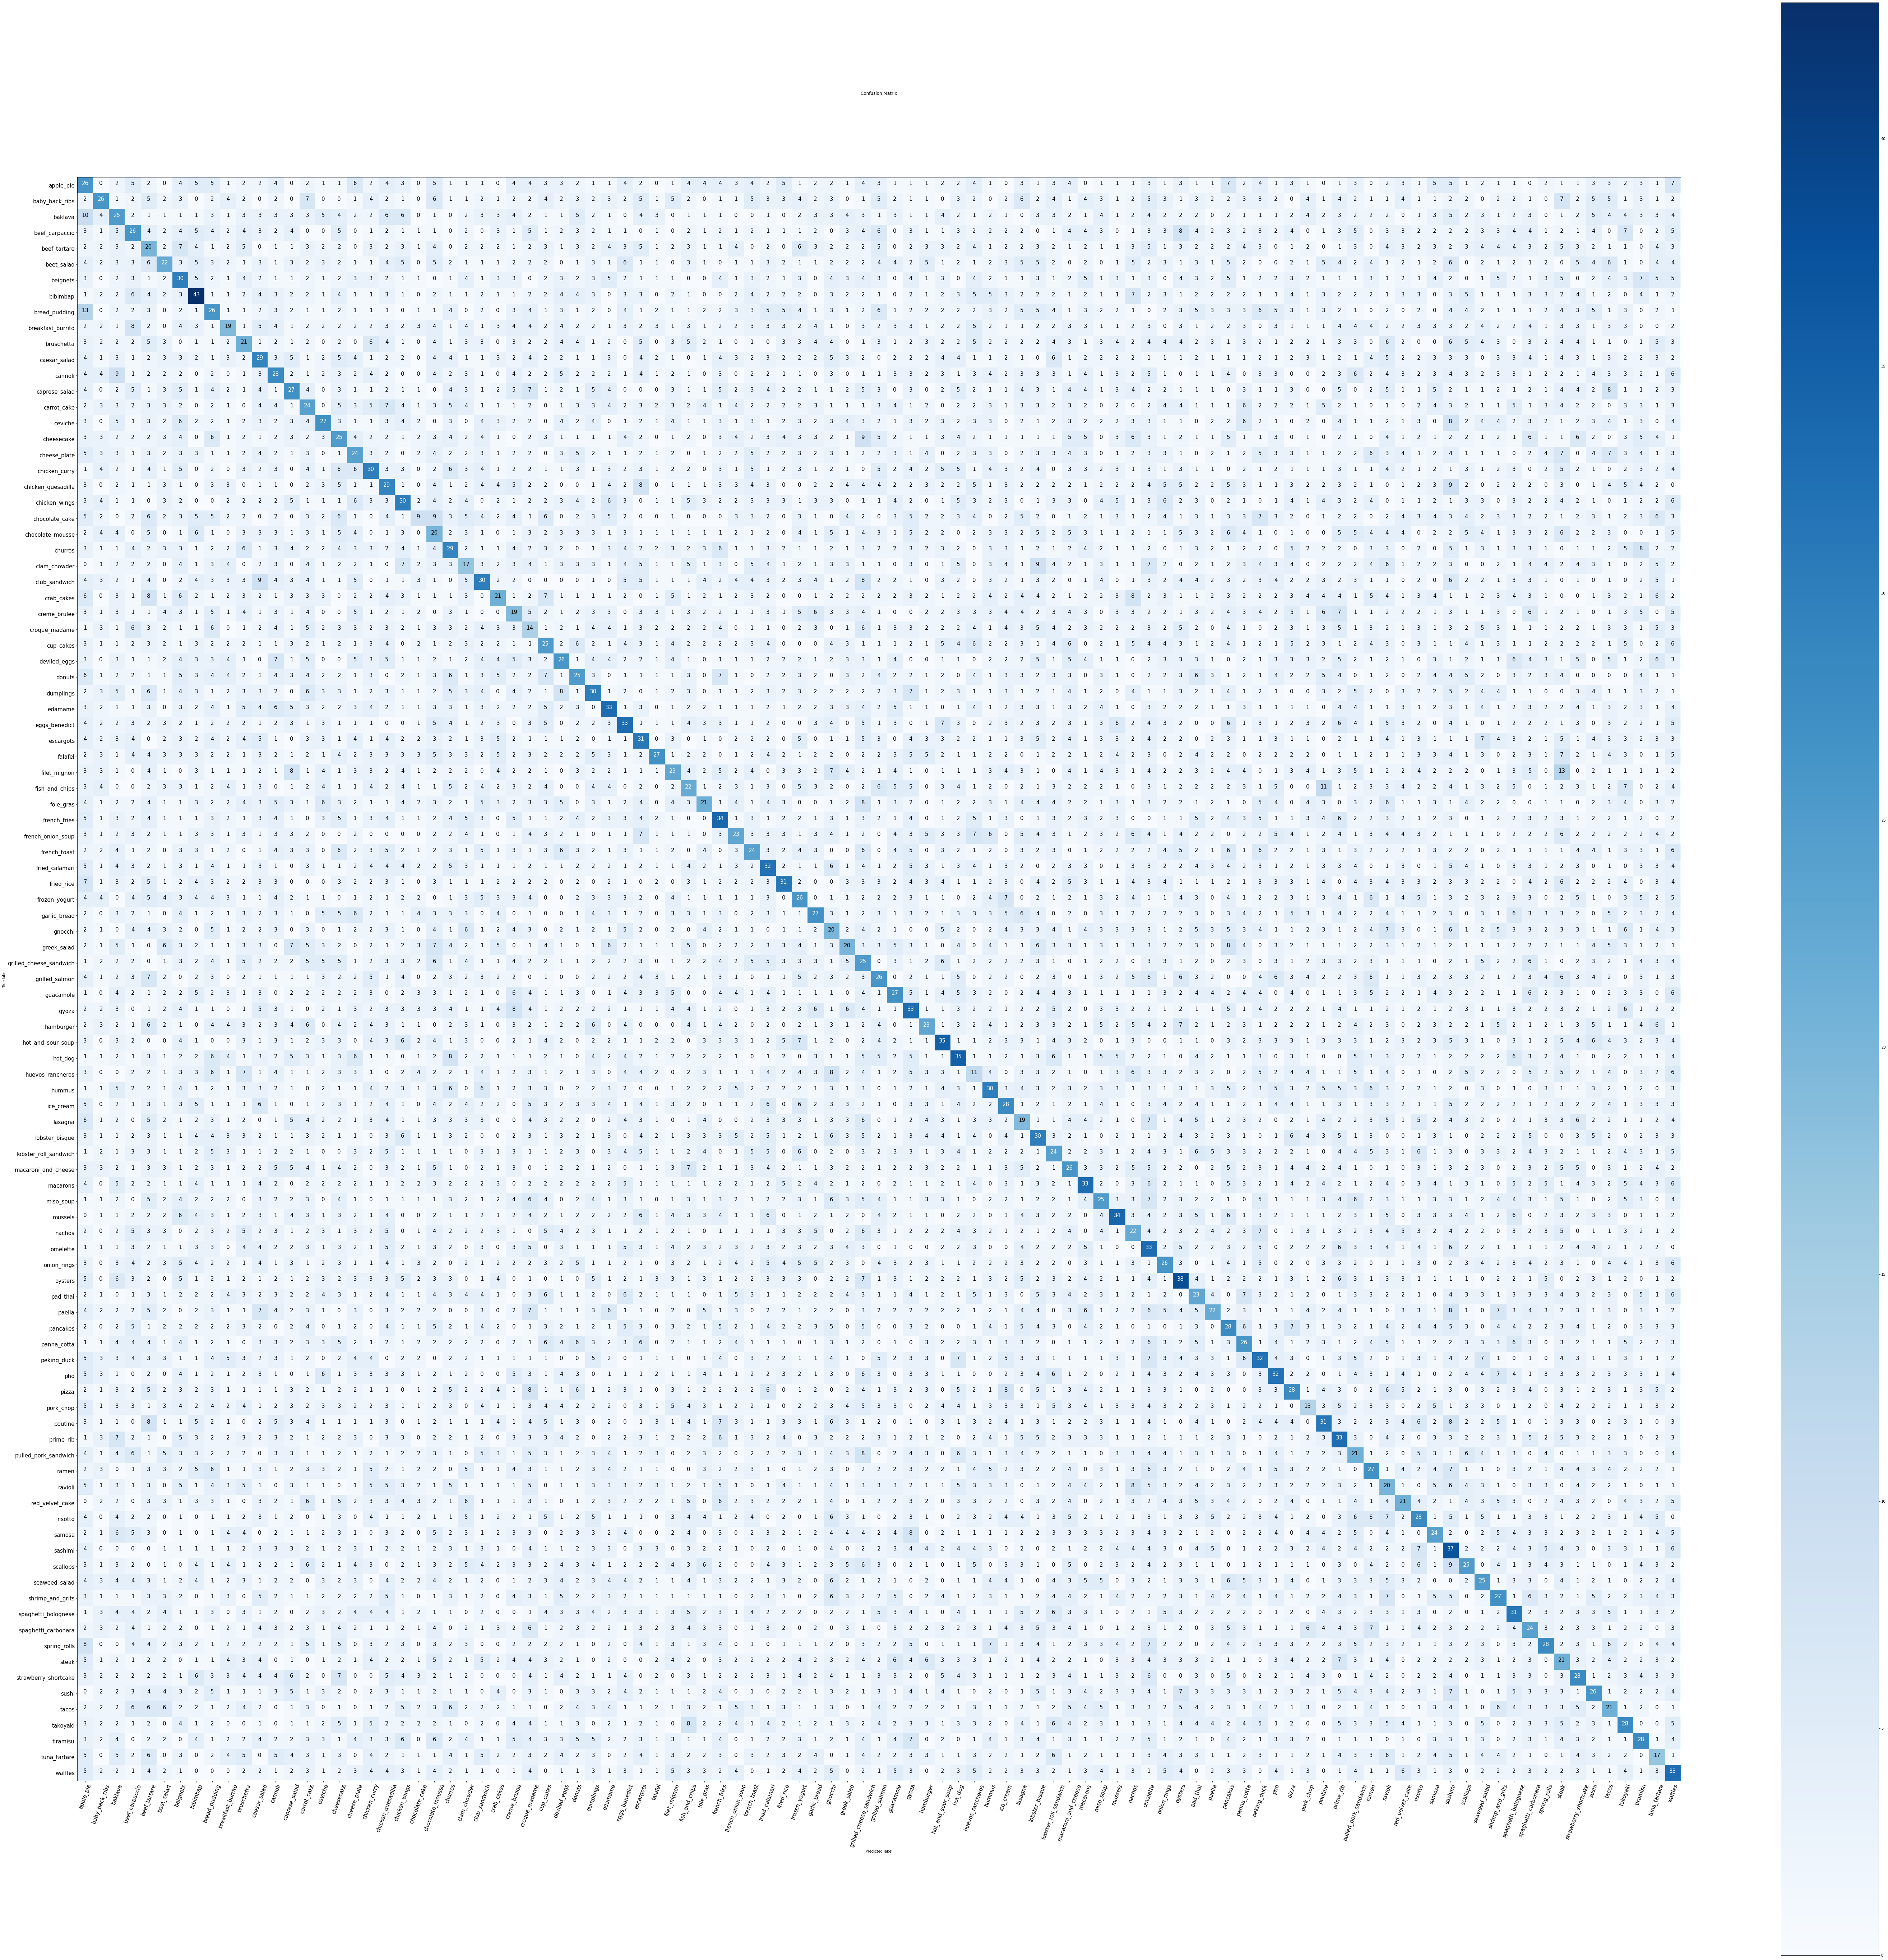

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes=class_names, figsize=(100,100))

## i).precision, recall and f1 scores for each class (all 101)